# LSTM for Time Series
### With TensorFlow/Keras: n steps forecasting

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

## Data preparation

Convert time series into supervised learning problem

In [2]:
def ts2sup_df(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Differentation

In [3]:
def diff(ds, span=1):
    diff_ts = list()
    for i in range(span, len(ds)):
        value = ds[i] - ds[i-span]
        diff_ts.append(value)
    return pd.Series(diff_ts)

def inverse_diff(last_ob, forecast):
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

Train and test

In [4]:
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    diff_series = diff(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = ts2sup_df(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

## Modelling

In [10]:
# fit an LSTM network to training data
def lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons):
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(n_epochs):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make one forecast with an LSTM,
def lstm_fcst(model, X, n_batch):
    X = X.reshape(1, 1, len(X))
    forecast = model.predict(X, batch_size=n_batch)
    return [x for x in forecast[0, :]]

# evaluate the persistence model
def naive_fcsts(model, train, test, n_batch, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        forecast = lstm_fcst(model, X, n_batch)
        forecasts.append(forecast)
    return forecasts

## Validation

In [18]:
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_diff(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
# plot the entire dataset in blue
    plt.figure(figsize=(20,10))
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    plt.show()

## Testing

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


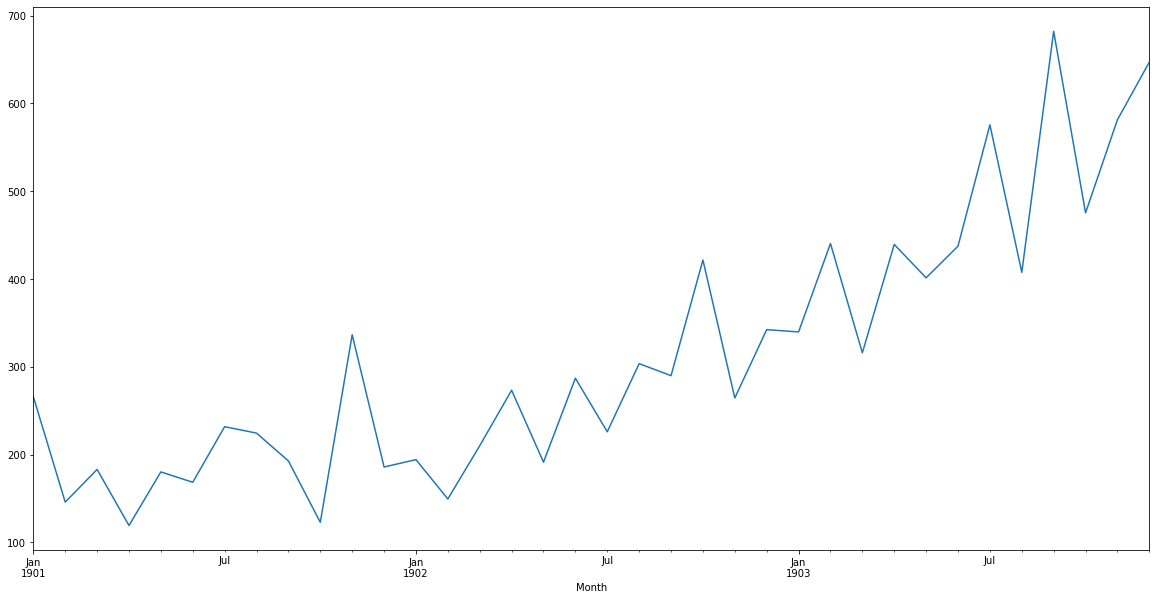

In [21]:
ts = pd.read_csv('D:/data/csv/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=lambda x: datetime.strptime('190'+x, '%Y-%m'))
print(ts.head())
plt.figure(figsize=(20,10))
ts.plot()
plt.show()

In [22]:
n_lag = 1
n_seq = 3
n_test = 10

scaler, train, test = prepare_data(ts, n_test, n_lag, n_seq)
model = lstm(train, n_lag=1, n_seq=3, n_batch=1, n_epochs=1500, n_neurons=1)

fcsts = naive_fcsts(model, train, test, n_batch=1, n_lag=1, n_seq=3)
fcsts = inverse_transform(ts, fcsts, scaler, n_test+2)

actual = [row[n_lag:] for row in test]
actual = inverse_transform(ts, actual, scaler, n_test+2)

t+1 RMSE: 124.249076
t+2 RMSE: 89.223034
t+3 RMSE: 109.904272


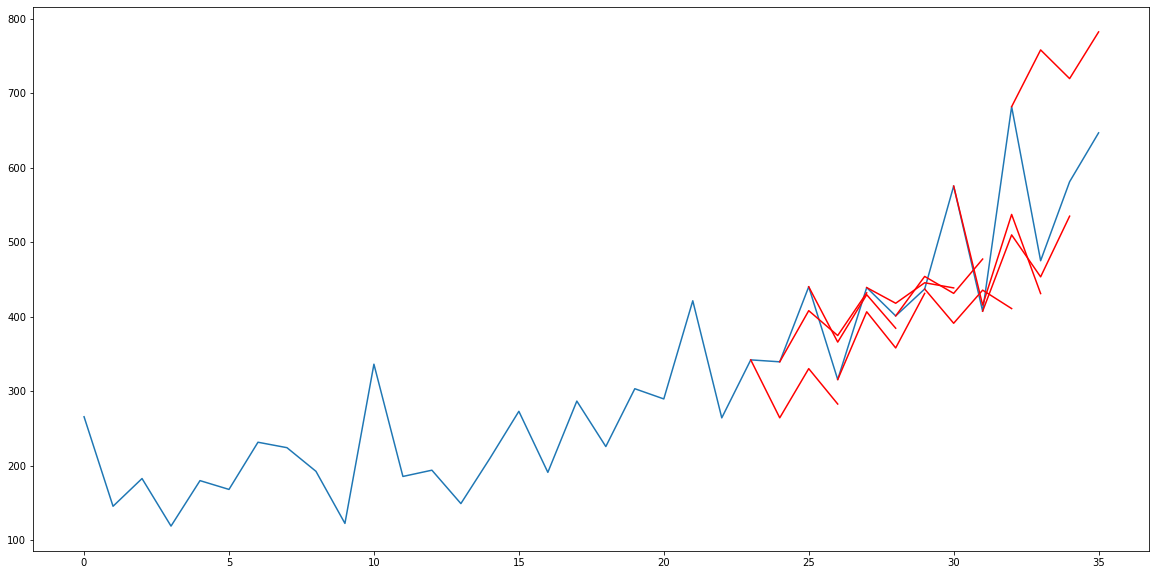

In [23]:
evaluate_forecasts(actual, fcsts, n_lag, n_seq)
plot_forecasts(ts, fcsts, n_test+2);

## Credits & Links

https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
https://www.curiousily.com/posts/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python/